In [21]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-05-23 12:46:09,017: Credentials are already in use. The existing account in the session will be replaced.


In [22]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import *#QasmSimulator
from qiskit.visualization import *
from qiskit.extensions import Initialize
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.extensions import Initialize



# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style


ibmqfactory.load_account:WARNING:2022-05-23 12:46:12,052: Credentials are already in use. The existing account in the session will be replaced.


Raw Image info: (32, 32, 4)
Raw Image datatype: uint8


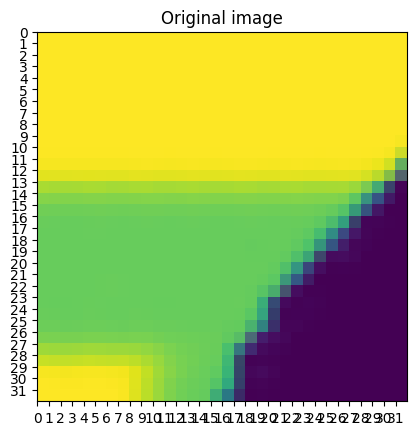

Image shape (numpy array): (32, 32)


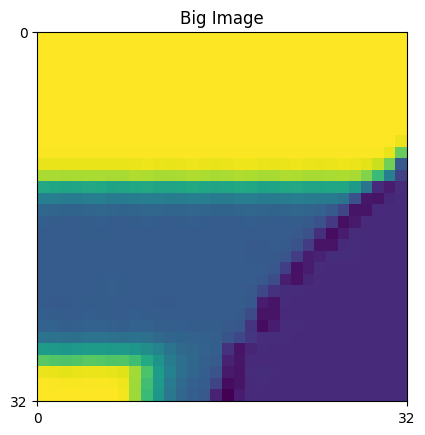

In [47]:
from PIL import Image
style.use('default')

image_size = 256       # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('img3.png'))
image_raw=image_raw[:32,:32]
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='plasma')
    plt.show()
    
plot_image(image_raw, 'Original image')


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_crop_size):
    image.append([])
    for j in range(image_crop_size):
        image[i].append(image_raw[i][j][0] /255)
            
image = np.array(image)
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

In [48]:
#Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)
print(image_norm_h)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

[0.04357812 0.04357812 0.04357812 ... 0.0117127  0.0117127  0.0117127 ]


In [49]:
data_qb = 10
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
print(D2n_1)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


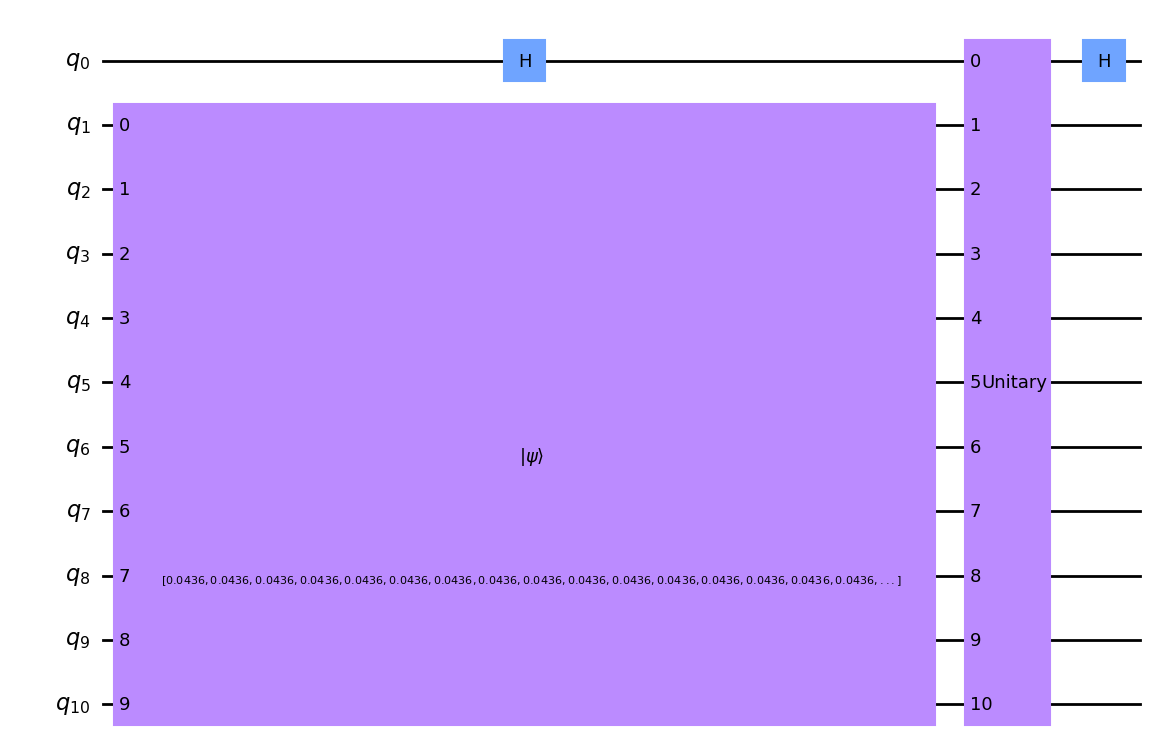

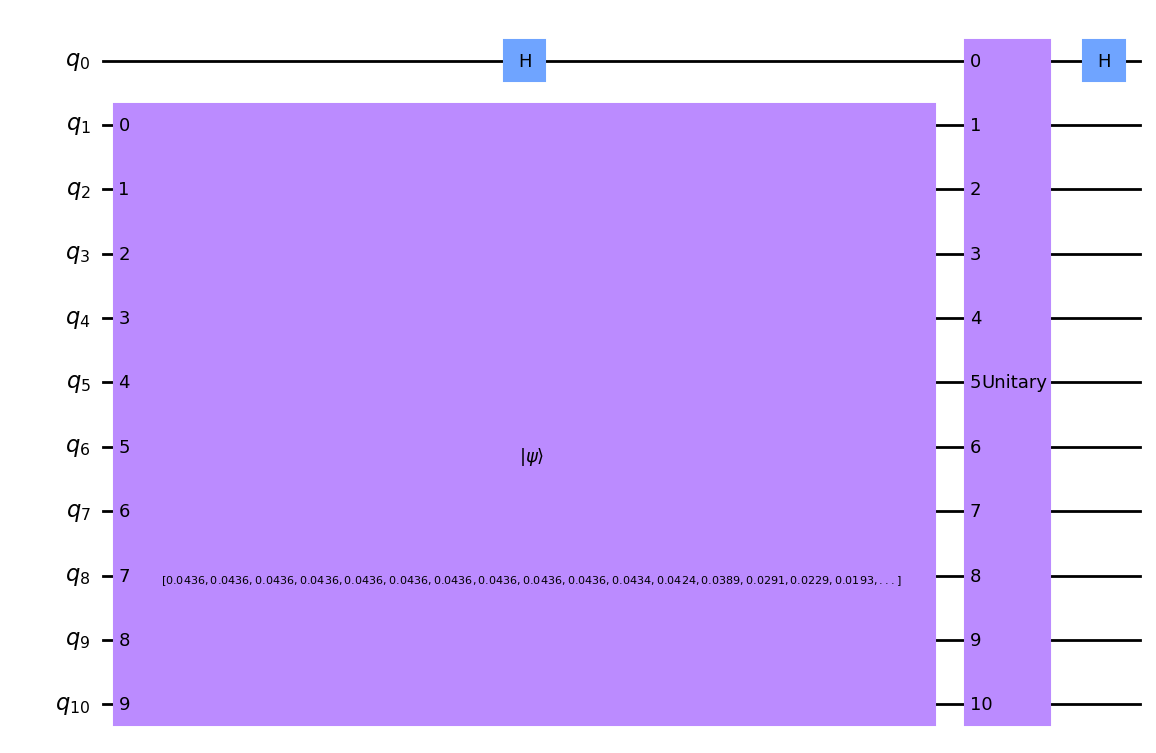

In [50]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw(output="mpl",fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw(output='mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [51]:
# Simulating the cirucits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)
sv_h=np.array(sv_h)
sv_v=np.array(sv_v)

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
display(array_to_latex(sv_h[0:30], max_size=30))
print('Vertical scan statevector:')
display(array_to_latex(sv_v[0:30], max_size=30))
#print(sv_h[27].real)
sv_h.shape

Horizontal scan statevector:


<IPython.core.display.Latex object>

Vertical scan statevector:


<IPython.core.display.Latex object>

(2048,)

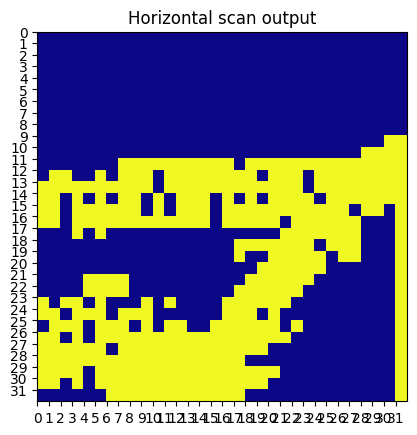

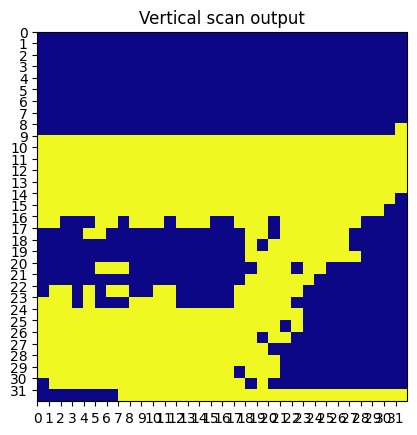

In [52]:
# Classical postprocessing for plotting the output
#128/2==64& |q4 q3 q2 q1 q0> q0=ancilla=lsb if lsb=1 then no=odd.
# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (abs(amp) > 1e-15)# or amp < -1e-15)

# Selecting odd states from the raw statevector as odd have gradient value ie. c0-c1,c1-c2.......... and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h1 = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32)
edge_scan_v1 = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h1, 'Horizontal scan output')
plot_image(edge_scan_v1, 'Vertical scan output')

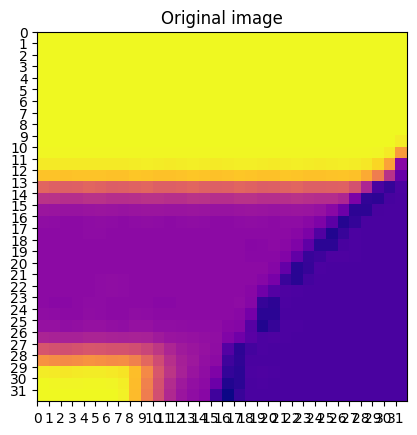

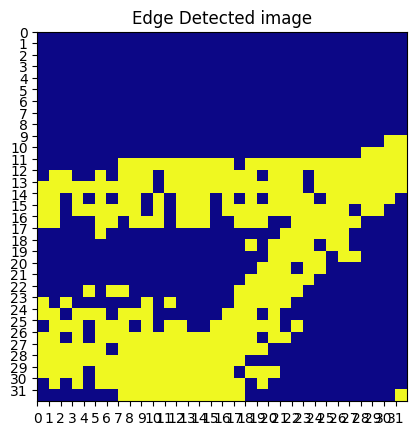

In [53]:
# Combining the horizontal and vertical component of the result
edge_scan_sim1 = edge_scan_h1&edge_scan_v1

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim1, 'Edge Detected image')

Raw Image info: (32, 32, 4)
Raw Image datatype: uint8


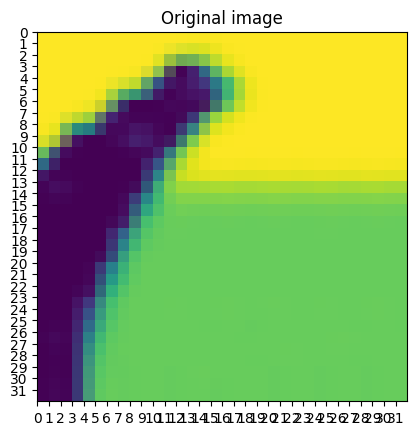

Image shape (numpy array): (32, 32)


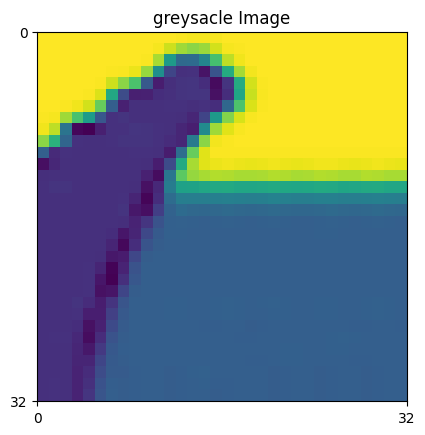

In [54]:
from PIL import Image
style.use('default')

image_size = 256       # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('img3.png'))
image_raw=image_raw[:32,32:64]
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='plasma')
    plt.show()
    
plot_image(image_raw, 'Original image')


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_crop_size):
    image.append([])
    for j in range(image_crop_size):
        image[i].append(image_raw[i][j][0] /255)
            
image = np.array(image)
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('greysacle Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

In [55]:
#Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)
print(image_norm_h)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

[0.05052865 0.05052865 0.05052865 ... 0.02037123 0.02057095 0.02057095]


In [56]:
data_qb = 10
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
print(D2n_1)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


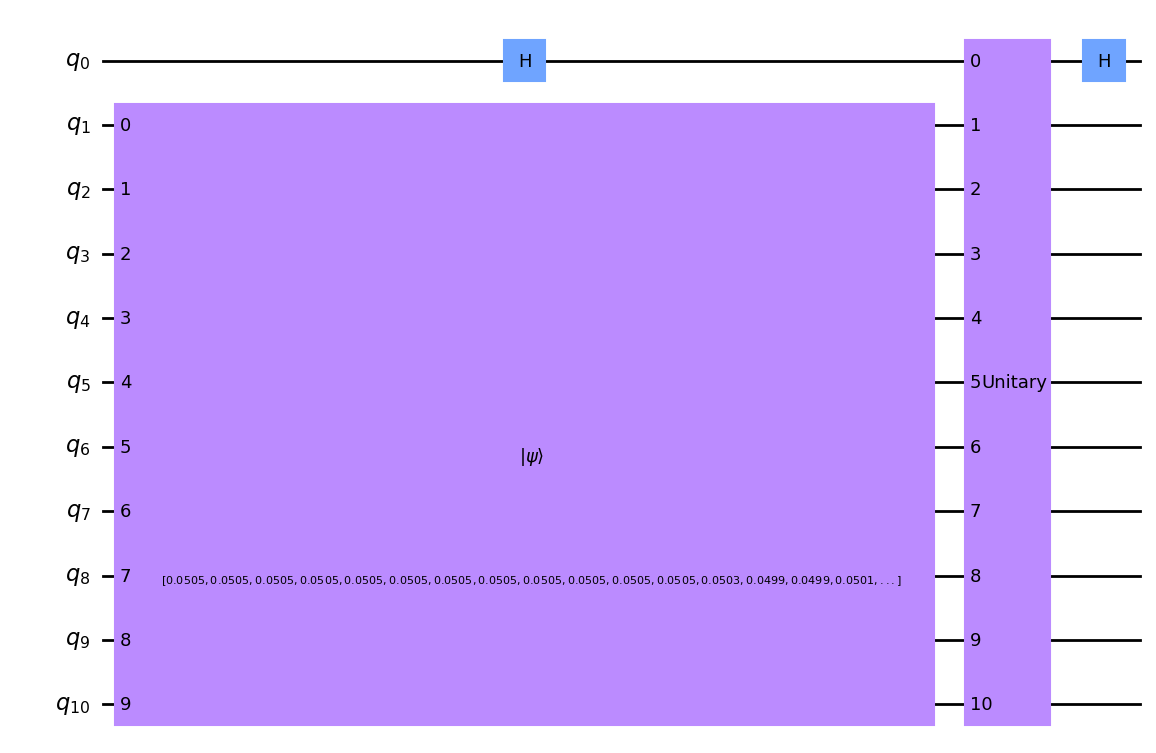

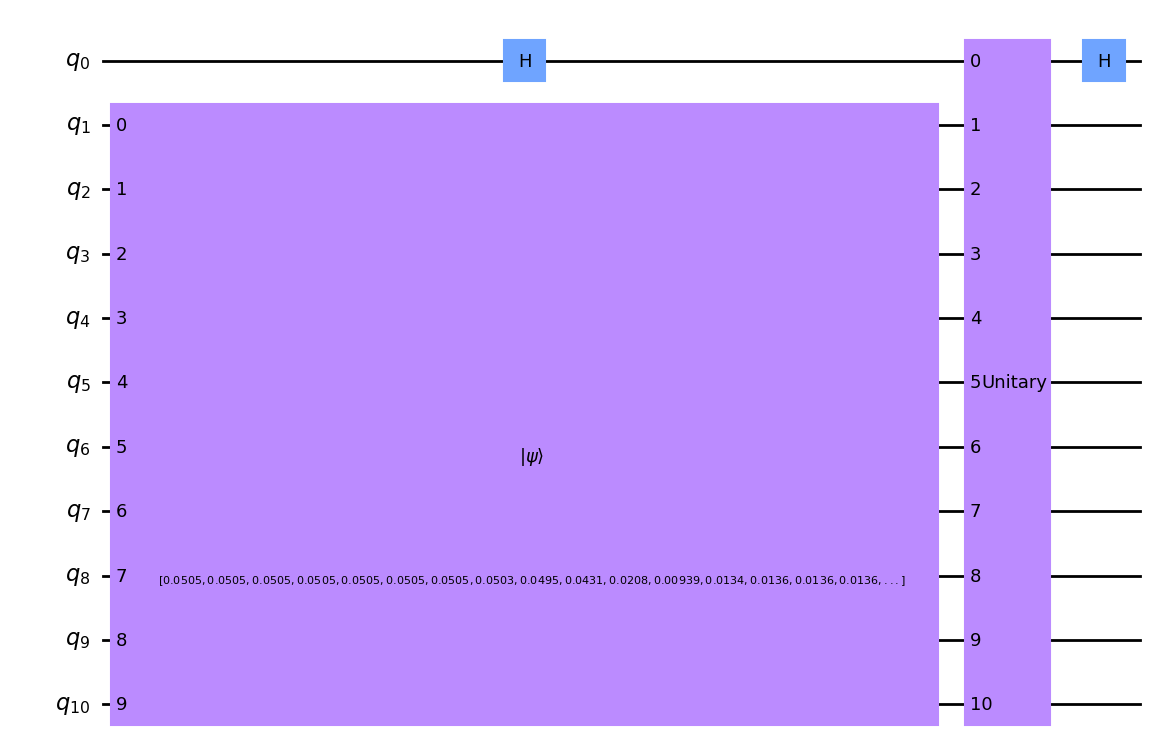

In [57]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw(output="mpl",fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw(output='mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [58]:
# Simulating the cirucits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)
sv_h=np.array(sv_h)
sv_v=np.array(sv_v)

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
display(array_to_latex(sv_h[0:30], max_size=30))
print('Vertical scan statevector:')
display(array_to_latex(sv_v[0:30], max_size=30))
#print(sv_h[27].real)
sv_h.shape

Horizontal scan statevector:


<IPython.core.display.Latex object>

Vertical scan statevector:


<IPython.core.display.Latex object>

(2048,)

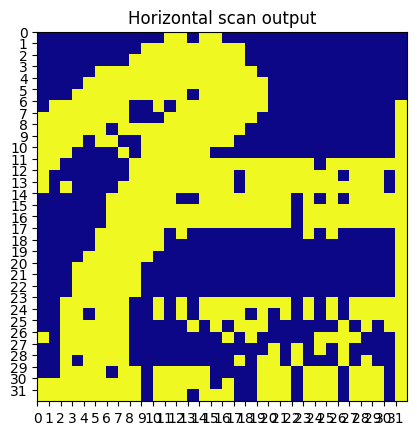

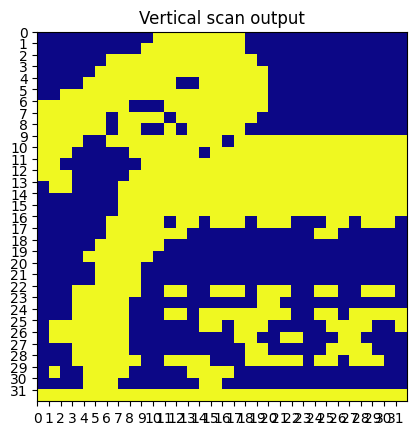

In [59]:
# Classical postprocessing for plotting the output
#128/2==64& |q4 q3 q2 q1 q0> q0=ancilla=lsb if lsb=1 then no=odd.
# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (abs(amp) > 1e-15)# or amp < -1e-15)

# Selecting odd states from the raw statevector as odd have gradient value ie. c0-c1,c1-c2.......... and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h2 = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32)
edge_scan_v2 = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h2, 'Horizontal scan output')
plot_image(edge_scan_v2, 'Vertical scan output')

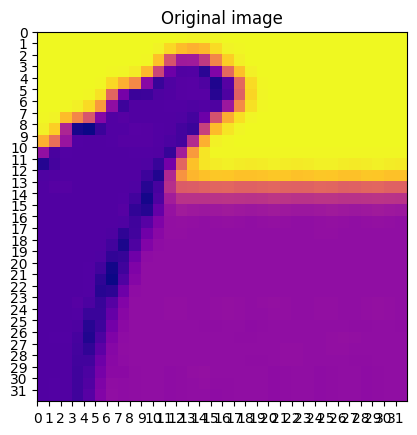

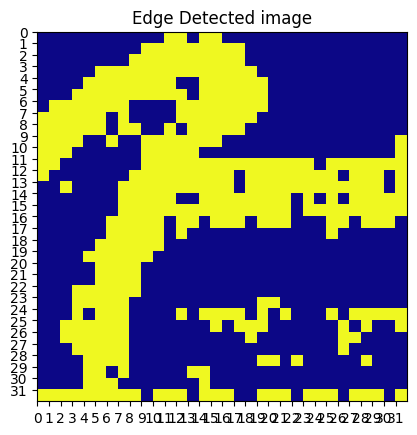

In [60]:
# Combining the horizontal and vertical component of the result
edge_scan_sim2 = edge_scan_h2&edge_scan_v2

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim2, 'Edge Detected image')

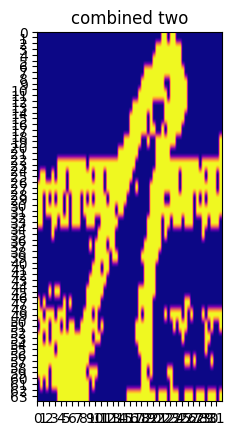

In [61]:
plot_image(np.concatenate((edge_scan_sim1,edge_scan_sim2),axis=1),'combined two')

Raw Image info: (32, 32, 4)
Raw Image datatype: uint8


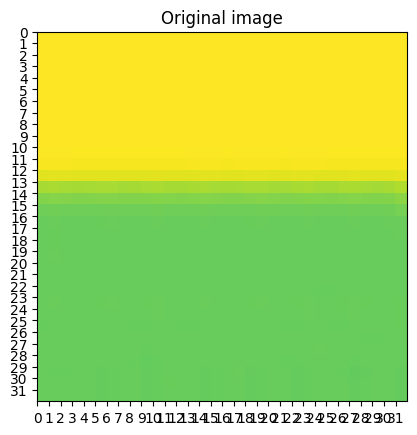

Image shape (numpy array): (32, 32)


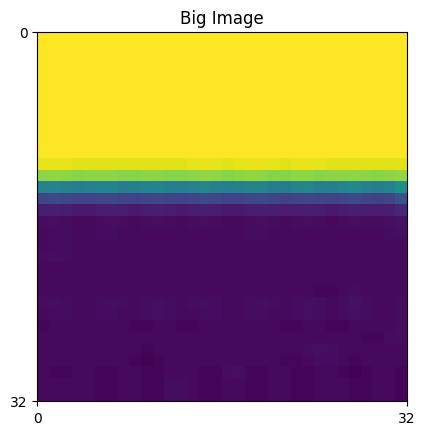

In [67]:
from PIL import Image
style.use('default')

image_size = 256       # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('img3.png'))
image_raw=image_raw[:32,64:96]
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='plasma')
    plt.show()
    
plot_image(image_raw, 'Original image')


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_crop_size):
    image.append([])
    for j in range(image_crop_size):
        image[i].append(image_raw[i][j][0] /255)
            
image = np.array(image)
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

In [68]:
#Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)
print(image_norm_h)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

[0.0437944  0.0437944  0.0437944  ... 0.01782934 0.01782934 0.01748314]


In [69]:
data_qb = 10
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
print(D2n_1)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


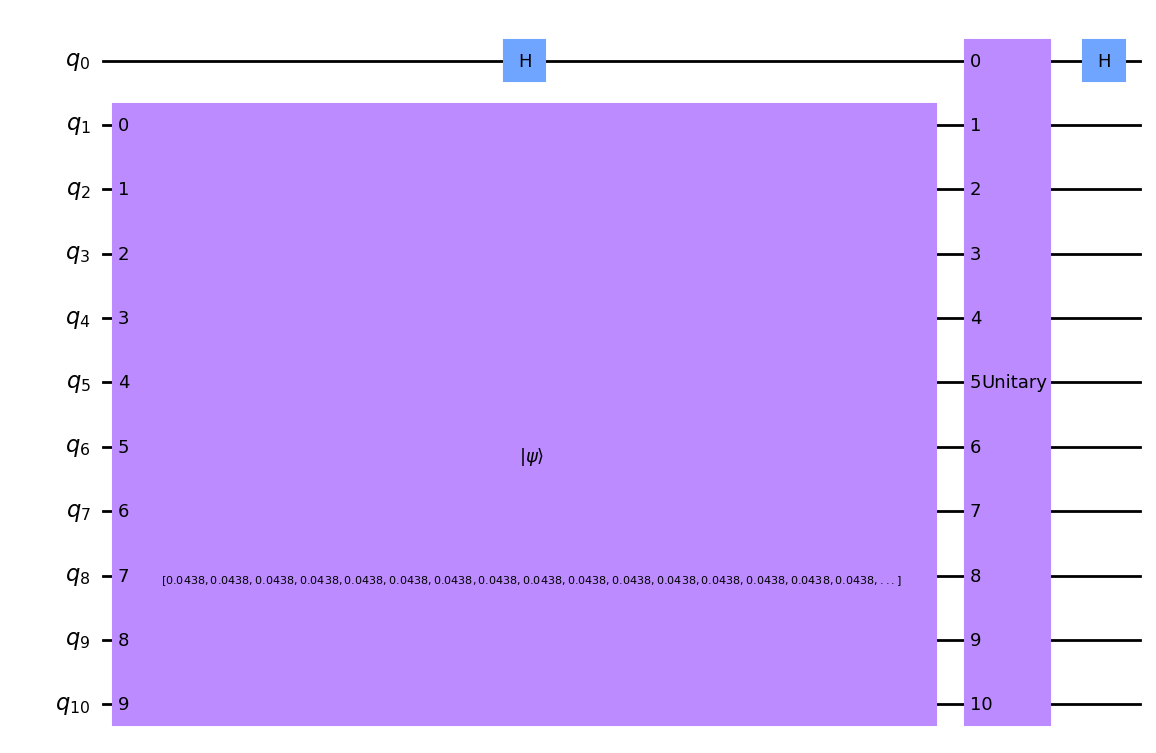

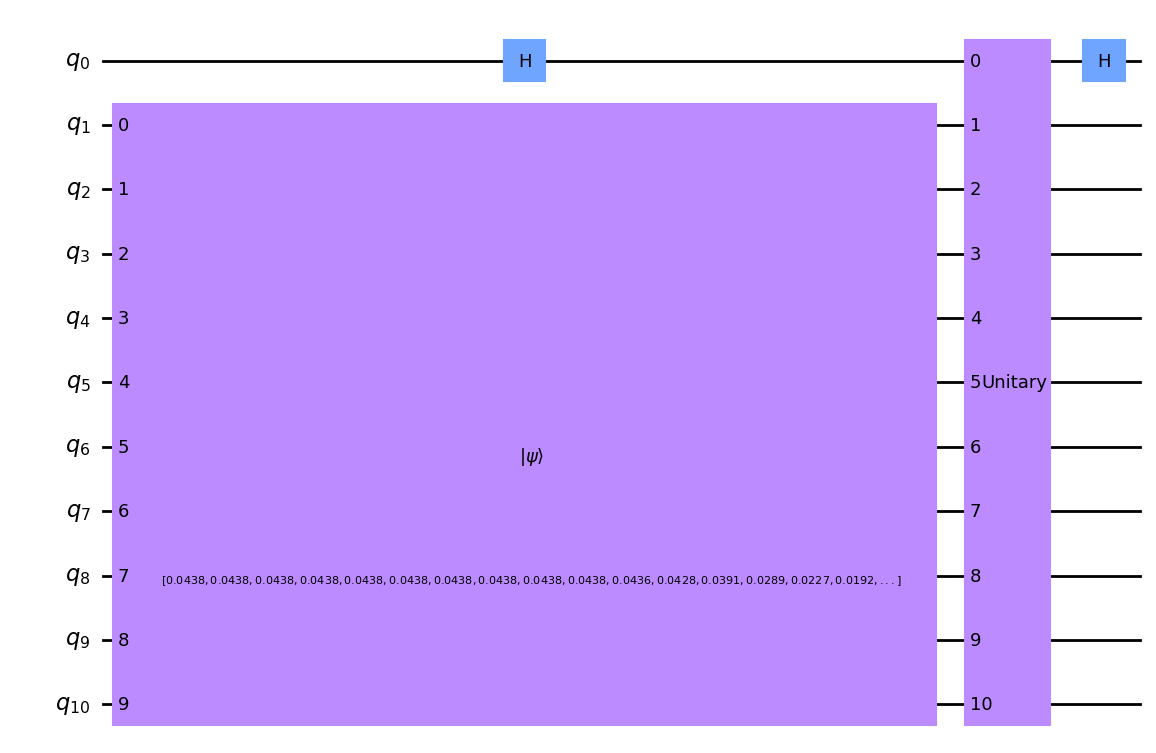

In [70]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw(output="mpl",fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw(output='mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [71]:
# Simulating the cirucits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)
sv_h=np.array(sv_h)
sv_v=np.array(sv_v)

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
display(array_to_latex(sv_h[0:30], max_size=30))
print('Vertical scan statevector:')
display(array_to_latex(sv_v[0:30], max_size=30))
#print(sv_h[27].real)
sv_h.shape

Horizontal scan statevector:


<IPython.core.display.Latex object>

Vertical scan statevector:


<IPython.core.display.Latex object>

(2048,)

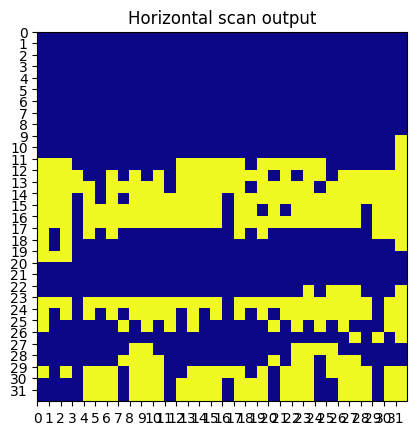

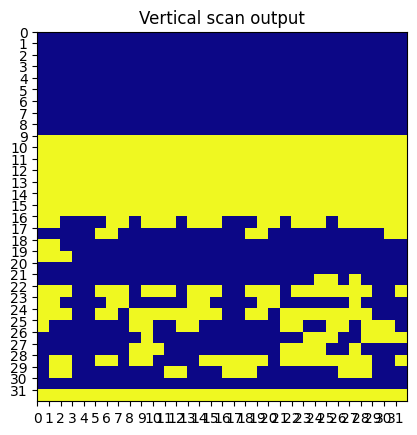

In [72]:
# Classical postprocessing for plotting the output
#128/2==64& |q4 q3 q2 q1 q0> q0=ancilla=lsb if lsb=1 then no=odd.
# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (abs(amp) > 1e-15)# or amp < -1e-15)

# Selecting odd states from the raw statevector as odd have gradient value ie. c0-c1,c1-c2.......... and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h3 = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32)
edge_scan_v3 = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h3, 'Horizontal scan output')
plot_image(edge_scan_v3, 'Vertical scan output')

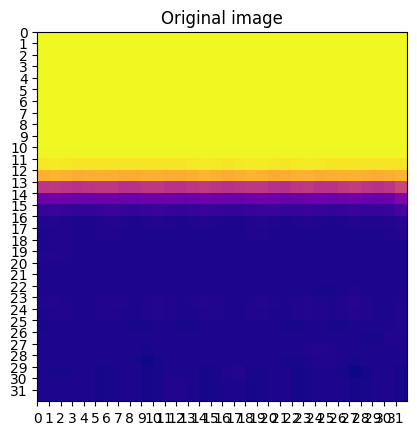

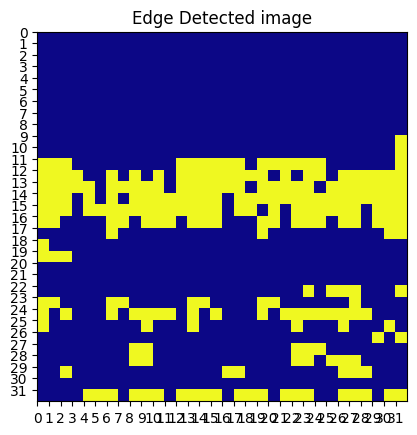

In [75]:
# Combining the horizontal and vertical component of the result
edge_scan_sim3 = edge_scan_h3&edge_scan_v3

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim3, 'Edge Detected image')

Raw Image info: (32, 32, 4)
Raw Image datatype: uint8


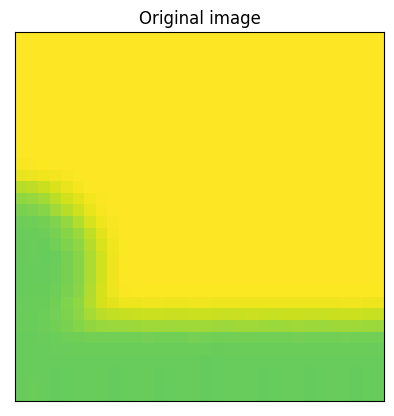

Image shape (numpy array): (32, 32)


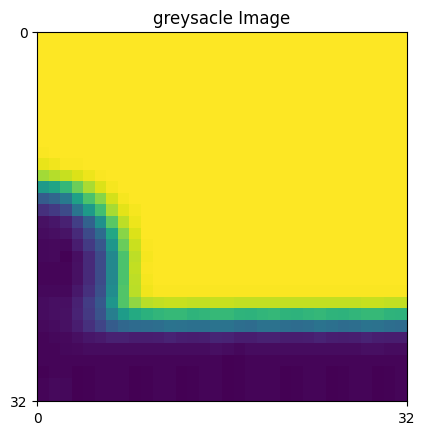

In [84]:
from PIL import Image
style.use('default')

image_size = 256       # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('img3.png'))
image_raw=image_raw[:32,96:128]
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]+1, 32))
    plt.yticks(range(img.shape[1]+1, 32))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='plasma')
    plt.show()
    
plot_image(image_raw, 'Original image')


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_crop_size):
    image.append([])
    for j in range(image_crop_size):
        image[i].append(image_raw[i][j][0] /255)
            
image = np.array(image)
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('greysacle Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

In [85]:
#Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)
print(image_norm_h)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

[0.03595816 0.03595816 0.03595816 ... 0.01435484 0.01449697 0.01463909]


In [86]:
data_qb = 10
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
print(D2n_1)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


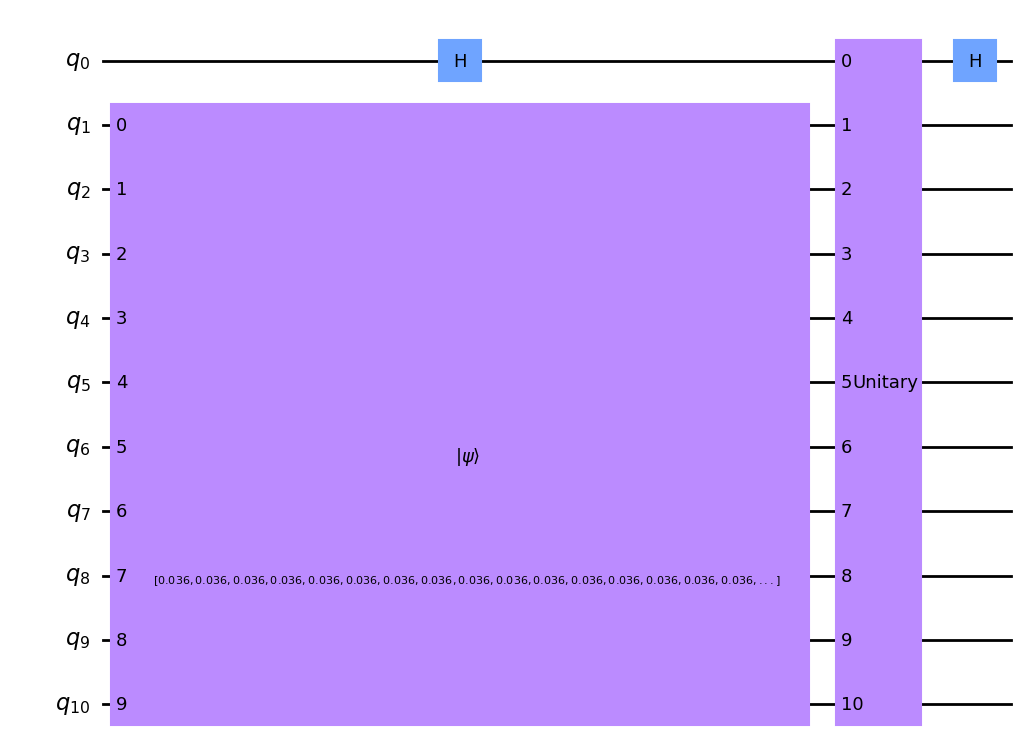

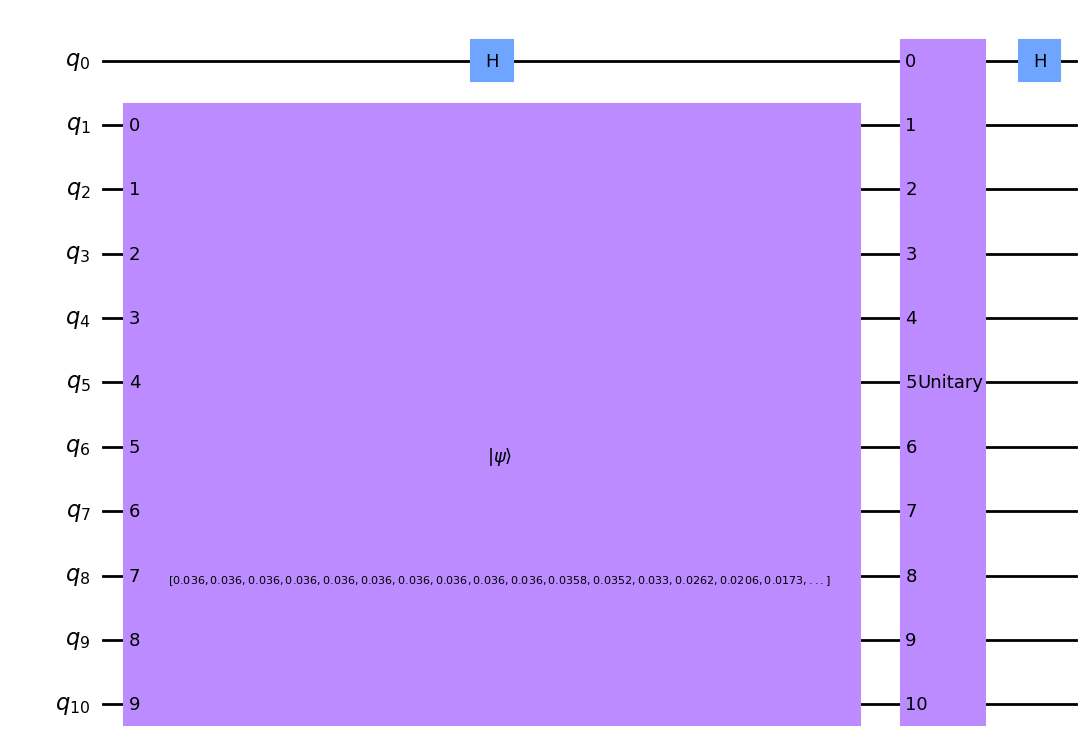

In [87]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw(output="mpl",fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw(output='mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [88]:
# Simulating the cirucits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)
sv_h=np.array(sv_h)
sv_v=np.array(sv_v)

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
display(array_to_latex(sv_h[0:30], max_size=30))
print('Vertical scan statevector:')
display(array_to_latex(sv_v[0:30], max_size=30))
#print(sv_h[27].real)
sv_h.shape

Horizontal scan statevector:


<IPython.core.display.Latex object>

Vertical scan statevector:


<IPython.core.display.Latex object>

(2048,)

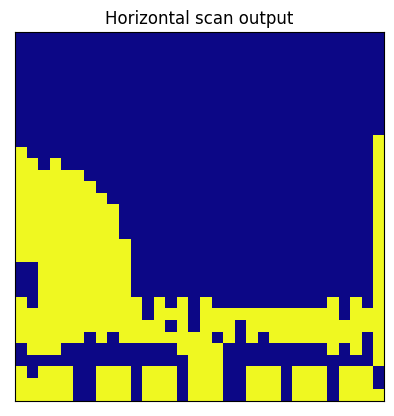

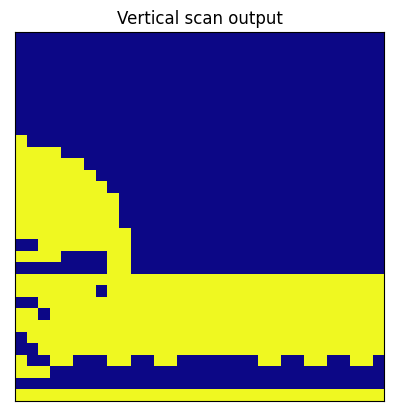

In [89]:
# Classical postprocessing for plotting the output
#128/2==64& |q4 q3 q2 q1 q0> q0=ancilla=lsb if lsb=1 then no=odd.
# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (abs(amp) > 1e-15)# or amp < -1e-15)

# Selecting odd states from the raw statevector as odd have gradient value ie. c0-c1,c1-c2.......... and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h4 = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32)
edge_scan_v4 = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h4, 'Horizontal scan output')
plot_image(edge_scan_v4, 'Vertical scan output')

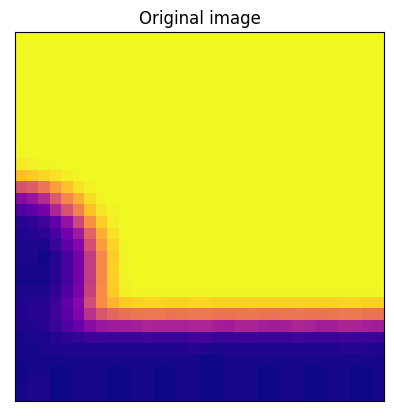

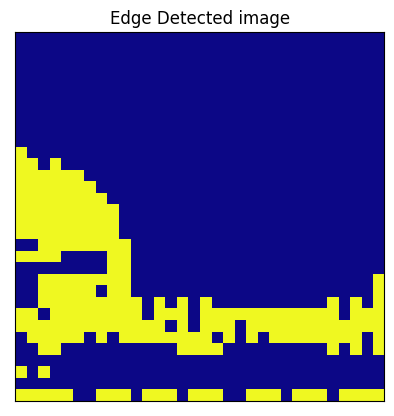

In [90]:
# Combining the horizontal and vertical component of the result
edge_scan_sim4 = edge_scan_h4&edge_scan_v4

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim4, 'Edge Detected image')

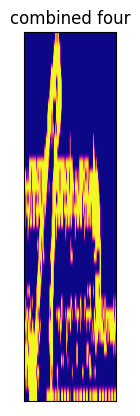

In [91]:
plot_image(np.concatenate((edge_scan_sim1,edge_scan_sim2,edge_scan_sim3,edge_scan_sim4),axis=1),'combined four')

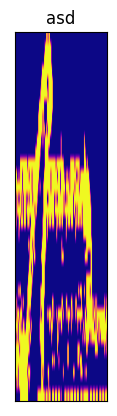

In [94]:
# plot_image(np.hstack((edge_scan_sim1,edge_scan_sim2,edge_scan_sim3,edge_scan_sim4)),'asd')